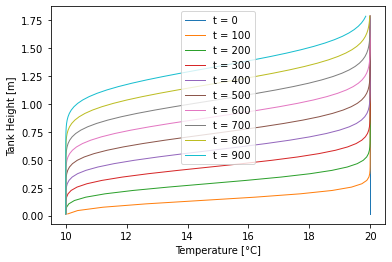

In [22]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 31 10:16:15 2022

@author: eusch
"""

# -*- coding: utf-8 -*-
"""
Multi-Node Method - 1D Stratified Sensible Storage Unit
https://github.com/DrTol/1D_Storage_Multi-Node_Model-Python 
Created on Sat Oct 31 12:18:27 2020
@author: Hakan İbrahim Tol, PhD
References:
[1] Kleinbach, Eberhard Markus; Performance study of one-dimensional models 
    for stratified thermal storage tank.
[2] Unrau, Cody; Numerical investigation of one-dimensional storage tank models
    and the development of analytical modelling techniques.
"""
%matplotlib inline

import numpy as np
from scipy.integrate import odeint
import math
import matplotlib.pyplot as plt

""" Input Operational Parameters """
mF_d   = 0.0                # [kg/s]    Mass flow rate - Charging [0.3]
mF_u   = 0.30                  # [kg/s]    Mass flow rate - Discharging [0]
Tcharg = 60                 # [°C]      Inlet water temperature - Charging [90]
Tmains = 10                 # [°C]      Inlet mains water temp. - Discharging

""" Tank Dimensions """
h_Tank = 1.8                # [m]       height of the tank [0.9]
d_Tank = 0.5                # [m]       diameter of the tank

""" Water Properties """
global rho,Cp,k
rho = 1000                  # [kg/m3]   Water density
Cp  = 4.1815*1000           # [J/kgK]   Water specific heat capacity
k   = 640.6/1000            # [W/mK]    Water thermal conductivity

""" Numerical Parameters """
n = 60                      # [-]       Number of Nodes [30]

global deltaX, dt
deltaX = h_Tank/n           # [m]       Node size/height
dt = 1                      # [s]       Time step
Nt = 1000                   # [-]       Number of time steps

t=np.arange(0, 2*dt, dt)    # [s]       Time points

Tpre=np.ones(n)*20          # [°C]      Initial temperature profile
                            #           along the tank height

""" Tank Size Calculations """
global A_Tank, Mi
A_Tank = math.pi * d_Tank**2 /4  # [m2]      cross-sectional area of the tank
V_Tank = A_Tank * h_Tank         # [m3]      volume of the tank
Mi = (V_Tank * rho) /n           # [kg]      mass of the node

""" Index for the Operational Mode """
i_charge    =np.array([0,0,1,0,1,0,1,1])
i_discharge =np.array([0,0,0,1,0,1,1,1])
i_idle      =np.array([0,0,0,0,0,0,1,1])

""" Index for the Node Location """
i_first     =np.array([1,0,1,1,1,1,1,0])
i_inner     =np.array([0,0,1,1,1,1,1,1])
i_last      =np.array([0,1,1,1,1,1,0,1])

""" Defining the Model """
# Cody Unrau, Thesis, Chapter 3, eq. (3.5)
# Tn    : Temperature at the north/above node
# Ts    : Temperature at the south/below node
# mF_d  : Downward mass flow rate (Charging)
# mF_u  : Upward mass flow rate (Discharging)
def model(T,t,i,Tn,Ts):
    dTdt=(i[0] * mF_d *Cp *Tn \
         -i[1] * mF_u *Cp *T  \
         +i[2] * mF_d *Cp *Tn \
         -i[3] * mF_u *Cp *T  \
         -i[4] * mF_d *Cp *T  \
         +i[5] * mF_u *Cp *Ts \
         +i[6] * k    *A_Tank /deltaX *(Ts-T) \
         +i[7] * k    *A_Tank /deltaX *(Tn-T)) /(Mi*Cp)
        
    return dTdt

""" Time to Run the Model """
# Checking the Operational Condition
if mF_d < 1.e-8 and mF_u < 1.e-8:
    i_temp = i_idle
elif mF_d >= mF_u:
    i_temp = i_charge
elif mF_d < mF_u:
    i_temp = i_discharge
"""
if mF_d >= mF_u:
    i_temp = i_charge
elif mF_d < mF_u:
    i_temp = i_discharge
elif mF_d == 0 and mF_u == 0:
    i_temp = i_idle
"""    
# Initializing the Tout matrix with ghost nodes at the top and bottom
Tout=np.zeros((n+2,Nt+1))
Tout[1:-1,0] = Tpre

# Adding values for the ghost node
if mF_d >= mF_u:
    Tout[0,:]=Tcharg
    Tout[-1,:]=Tmains
elif mF_d < mF_u:
    Tout[0,:]=Tpre[0]
    Tout[-1,:]=Tmains
else:
    Tout[0,:]=Tpre[0]
    Tout[-1,:]=Tpre[-1]

""" Fasten Your Seat Belts """

for iT in range(1,Nt+1):
    for iS in range(1,n+1):
        # print(iS)
        if iS == 1:
            i=i_temp*i_first
        elif iS == n:
            i=i_temp*i_last
        else:
            i=i_temp*i_inner

        #print('i = {:}'.format(str(np.array(i))))   
        Tn=Tout[iS-1,iT-1]
        Ts=Tout[iS+1,iT-1]
        
        Tresult= odeint(model,Tout[iS,iT-1],t,args=(i,Tn,Ts,))
    
        Tout[iS,iT]=Tresult[1] 

""" Plotting the Result """
# Removing the Ghost Nodes (bottom and top rows)
Tout=np.delete(Tout, 0, 0)
Tout=np.delete(Tout, -1, 0)

# Array for the tank height
x_h=np.arange(0+deltaX/2,h_Tank+deltaX/2,deltaX)

# Time Data
N_plot=10 # Number of plots
t_interval=(Nt+1)*dt//N_plot
t_plot=np.arange(0,t_interval*N_plot,t_interval)

# Plot in loop
for i,value in enumerate(t_plot):
    
    plt.plot(np.flip(Tout[:,i*t_interval]),x_h,linewidth=1,
             label='t = '+str(i*t_interval))

plt.xlabel('Temperature [°C]')
plt.ylabel('Tank Height [m]')
plt.legend()
plt.show()


In [24]:
mF_d = 0.0
mF_u = 0.0

print(f'mF_d = {mF_d:.10f}, mF_u = {mF_u:.10f}')
i_sign =np.array([1,-1,1,-1,-1,1,1,1]) 
""" Index for the Operational Mode """
i_charge    =np.array([0,0,1,0,1,0,1,1])
i_discharge =np.array([0,0,0,1,0,1,1,1])
i_idle      =np.array([0,0,0,0,0,0,1,1])
print('i_charge    = {:}'.format(str(np.array(i_charge)))) 
print('i_discharge = {:}'.format(str(np.array(i_discharge)))) 
print('i_idle      = {:}\n'.format(str(np.array(i_idle)))) 

""" Index for the Node Location """
i_first     =np.array([1,0,1,1,1,1,1,0])
i_inner     =np.array([0,0,1,1,1,1,1,1])
i_last      =np.array([0,1,1,1,1,1,0,1])
print('i_first     = {:}'.format(str(np.array(i_first)))) 
print('i_inner     = {:}'.format(str(np.array(i_inner)))) 
print('i_last      = {:}\n'.format(str(np.array(i_last)))) 

""" Time to Run the Model """
# Checking the Operational Condition
if mF_d < 1.e-8 and mF_u < 1.e-8:
    i_temp = i_idle
elif mF_d >= mF_u:
    i_temp = i_charge
elif mF_d < mF_u:
    i_temp = i_discharge

print('i_temp      = {:}\n'.format(str(np.array(i_temp)))) 
    
""" Fasten Your Seat Belts """
Nt = 1
n = 3

for iT in range(1,Nt+1):
    for iS in range(1,n+1):
        print(f'iS = {iS}')
        if iS == 1:
            i=i_temp*i_first*i_sign
        elif iS == n:
            i=i_temp*i_last*i_sign
        else:
            i=i_temp*i_inner*i_sign

        print('i = {:}'.format(str(np.array(i))))   


mF_d = 0.0000000000, mF_u = 0.0000000000
i_charge = [0 0 1 0 1 0 1 1]
i_discharge = [0 0 0 1 0 1 1 1]
i_idle = [0 0 0 0 0 0 1 1]

i_first = [1 0 1 1 1 1 1 0]
i_inner = [0 0 1 1 1 1 1 1]
i_last = [0 1 1 1 1 1 0 1]

i_temp = [0 0 0 0 0 0 1 1]

iS = 1
i = [0 0 0 0 0 0 1 0]
iS = 2
i = [0 0 0 0 0 0 1 1]
iS = 3
i = [0 0 0 0 0 0 0 1]
